### Configurações de ambiente

In [1]:
# === Standard Library ===
import json
import os
import re
import string
import copy
import random

# === Third-party Libraries ===

# Data handling
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Visualization
from great_tables import GT, md, html
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

# Plotly high-resolution export settings
plotly.io.renderers.default = "png"

# Set default font to Helvetica Neue in Plotly
plotly.io.templates["custom"] = plotly.io.templates["plotly_white"]
plotly.io.templates["custom"].layout.font.family = "Helvetica Neue"
plotly.io.templates.default = "custom"

# Matplotlib high-resolution settings
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.family"] = "Helvetica Neue"

# Machine Learning & Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)

# Optimization
# import optuna

# External integrations
import kagglehub

# === Project-specific Imports ===
from neural_networks.lstm import LSTMClassifier
from neural_networks.rnn import RNNClassifier

/Users/vkz/mini-projeto-2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [ ]:
SEED = 123
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(SEED)

try:
    torch.use_deterministic_algorithms(True)
except RuntimeError as e:
    print("⚠️  MPS op without deterministic implementation encountered:", e)

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [4]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /Users/vkz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vkz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vkz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/vkz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
nltk.data.path.append("/Users/vkz/nltk_data")

In [6]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [7]:
path = kagglehub.dataset_download("charunisa/chatgpt-sentiment-analysis")
df = pd.read_csv(os.path.join(path, "file.csv"))
df = df.drop(columns=["Unnamed: 0"])
label_map = {"bad": 0, "neutral": 1, "good": 2}
df["labels"] = df["labels"].map(label_map)
df

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,1
1,"Try talking with ChatGPT, our new AI system wh...",2
2,ChatGPT: Optimizing Language Models for Dialog...,1
3,"THRILLED to share that ChatGPT, our new model ...",2
4,"As of 2 minutes ago, @OpenAI released their ne...",0
...,...,...
219289,Other Software Projects Are Now Trying to Repl...,0
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,2
219291,chatgpt is being disassembled until it can onl...,0
219292,2023 predictions by #chatGPT. Nothing really s...,0


## Tratamento de dados

Balanceando as classes do dataset

In [8]:
bad_df = df[df["labels"] == 0]
neutral_df = df[df["labels"] == 1]
good_df = df[df["labels"] == 2]

min_count = min(len(bad_df), len(neutral_df), len(good_df))

bad_bal = resample(bad_df, n_samples=min_count, random_state=SEED)
neutral_bal = resample(neutral_df, n_samples=min_count, random_state=SEED)
good_bal = resample(good_df, n_samples=min_count, random_state=SEED)

df_balanced = (
    pd.concat([bad_bal, neutral_bal, good_bal])
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)

df = df_balanced.copy()
print(df["labels"].value_counts())

labels
1    55487
2    55487
0    55487
Name: count, dtype: int64


Removendo elementos da internet

In [9]:
def strip_text(text: str) -> str:
    text = text.replace("\\n", " ").replace("\n", " ")  # remove newlines
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = re.sub(r"#\w+", "", text)  # remove hashtags
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # normalize whitespace
    return text

In [10]:
df["stripped_tweets"] = df["tweets"].apply(strip_text)
df

,tweets,labels,stripped_tweets
0,I think I'll always remember the mix of awe &a...,1,i think ill always remember the mix of awe amp...
1,I too realized this the moment I used ChatGPT....,1,i too realized this the moment i used chatgpt ...
2,ChatGPT is mind-blowing.\nRunning out of ideas...,2,chatgpt is mindblowing running out of ideas fo...
3,For those saying ChatGPT will replace GOOG / S...,0,for those saying chatgpt will replace goog sta...
4,"Free speech is a fundamental right, but it is ...",2,free speech is a fundamental right but it is n...
...,...,...,...
166456,"This ChatGPT is weird, still sounds like a cus...",2,this chatgpt is weird still sounds like a cust...
166457,Can’t wait to see ChatGPT but with pronunciati...,2,cant wait to see chatgpt but with pronunciatio...
166458,ChatGPT is 🔥 https://t.co/xuMdkySoFM,0,chatgpt is
166459,ChatGPT is going to completely wreck content m...,0,chatgpt is going to completely wreck content m...


Aplicando lemmatização

In [11]:
tokenizer = TreebankWordTokenizer()


def normalize_text(text: str) -> str:
    words = tokenizer.tokenize(text)
    cleaned = [
        lemmatizer.lemmatize(w)
        for w in words
        if w.lower() not in stop_words and w not in string.punctuation
    ]
    return " ".join(cleaned)

In [12]:
df["normalized_tweets"] = df["stripped_tweets"].apply(normalize_text)
df

,tweets,labels,stripped_tweets,normalized_tweets
0,I think I'll always remember the mix of awe &a...,1,i think ill always remember the mix of awe amp...,think ill always remember mix awe amp exciteme...
1,I too realized this the moment I used ChatGPT....,1,i too realized this the moment i used chatgpt ...,realized moment used chatgpt way see future sh...
2,ChatGPT is mind-blowing.\nRunning out of ideas...,2,chatgpt is mindblowing running out of ideas fo...,chatgpt mindblowing running idea blog example ...
3,For those saying ChatGPT will replace GOOG / S...,0,for those saying chatgpt will replace goog sta...,saying chatgpt replace goog stackoverflow etc
4,"Free speech is a fundamental right, but it is ...",2,free speech is a fundamental right but it is n...,free speech fundamental right absolute restric...
...,...,...,...,...
166456,"This ChatGPT is weird, still sounds like a cus...",2,this chatgpt is weird still sounds like a cust...,chatgpt weird still sound like customer suppor...
166457,Can’t wait to see ChatGPT but with pronunciati...,2,cant wait to see chatgpt but with pronunciatio...,cant wait see chatgpt pronunciation recognitio...
166458,ChatGPT is 🔥 https://t.co/xuMdkySoFM,0,chatgpt is,chatgpt
166459,ChatGPT is going to completely wreck content m...,0,chatgpt is going to completely wreck content m...,chatgpt going completely wreck content marketi...


Construindo vocabulário

In [13]:
from collections import Counter


def build_vocab(texts, min_freq=2):
    counter = Counter()
    for tweet in texts:
        counter.update(tweet.split())
    vocab = {"<pad>": 0, "<unk>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab


vocab = build_vocab(df["normalized_tweets"])
vocab_size = len(vocab)

with open("nlp/vocab.json", "w") as f:
    json.dump(vocab, f)

In [14]:
def tweet_to_indices(tweet, vocab):
    return [vocab.get(word, vocab["<unk>"]) for word in tweet.split()]


df["indexed_tweets"] = df["normalized_tweets"].apply(
    lambda x: tweet_to_indices(x, vocab)
)

In [15]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.sequences = [torch.tensor(seq, dtype=torch.long) for seq in texts]
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded = pad_sequence(sequences, batch_first=True, padding_value=vocab["<pad>"])
    return padded, torch.tensor(labels)

In [16]:
train_df, test_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df_balanced["labels"],
    random_state=SEED,
)

train_df, holdout_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["labels"],
    random_state=SEED,
)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"Holdout size: {len(holdout_df)}")

print("\nTrain distribution:\n", train_df["labels"].value_counts())
print("\nTest distribution:\n", test_df["labels"].value_counts())
print("\nHoldout distribution:\n", holdout_df["labels"].value_counts())

Train size: 104869
Test size: 49939
Holdout size: 11653

Train distribution:
 labels
1    34957
0    34956
2    34956
Name: count, dtype: int64

Test distribution:
 labels
2    16647
1    16646
0    16646
Name: count, dtype: int64

Holdout distribution:
 labels
0    3885
1    3884
2    3884
Name: count, dtype: int64


In [17]:
train_df

,tweets,labels,stripped_tweets,normalized_tweets,indexed_tweets
140878,ChatGPT be glowin' pretty hard https://t.co/lA...,1,chatgpt be glowin pretty hard,chatgpt glowin pretty hard,"[14, 1, 808, 1996]"
135789,https://t.co/SqfL0G7rJL Develops AI Content De...,0,develops ai content detection for gpt3 and cha...,develops ai content detection gpt3 chatgpt int...,"[6252, 108, 732, 4449, 564, 14, 129, 3906, 625..."
146536,Argentina has not won #FIFAWorldCupFinal once ...,2,argentina has not won once in 1987 just look a...,argentina 1987 look response,"[7824, 1, 1224, 777]"
20900,“Using ChatGPT CODEX(!) To Build Web3 Scam Sea...,0,using chatgpt codex to build web3 scam search ...,using chatgpt codex build web3 scam search app...,"[106, 14, 1200, 352, 4090, 3581, 117, 255, 313..."
47142,Wow 😲😍 @OpenAI's ChatGPT is most amazing pers...,2,wow s chatgpt is most amazing person i meet in...,wow chatgpt amazing person meet entire life,"[121, 14, 228, 375, 2936, 649, 390]"
...,...,...,...,...,...
44836,Most tweeted articles today in Artificial Inte...,2,most tweeted articles today in artificial inte...,tweeted article today artificial intelligence ...,"[3233, 577, 215, 171, 172, 14, 3375, 64, 171, ..."
100513,Sophisticated mimicry of human conversation. T...,1,sophisticated mimicry of human conversation th...,sophisticated mimicry human conversation syste...,"[266, 11071, 675, 1496, 678, 675, 848, 8, 1874..."
42978,"Today, I used ChatGPT to make me a better Reac...",2,today i used chatgpt to make me a better react...,today used chatgpt make better react developer...,"[215, 27, 14, 317, 1042, 1296, 454, 2294, 611,..."
111363,ChatGPT temperature is too high. Needs a mode ...,1,chatgpt temperature is too high needs a mode f...,chatgpt temperature high need mode creativity ...,"[14, 7871, 1059, 485, 1550, 426, 1550, 855, 2073]"


Criando camadas de embedding e abstrações para passar os dados para as redes neurais

In [18]:
train_dataset = TweetDataset(train_df["indexed_tweets"], train_df["labels"])
test_dataset = TweetDataset(test_df["indexed_tweets"], test_df["labels"])
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)

In [19]:
embedding_dim = 100  # TODO: tunar

embedding_layer = torch.nn.Embedding(
    num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=vocab["<pad>"]
)

In [20]:
GRAPHS_PATH = os.path.join(os.getcwd(), "graphs")

In [21]:
def save_classification_report(all_labels, all_preds, filename):
    report = classification_report(
        all_labels,
        all_preds,
        target_names=["Bad", "Neutral", "Good"],
        digits=4,
        output_dict=True,
    )
    df_report = pd.DataFrame(report).T

    columns_order = ["precision", "recall", "f1-score", "support"]
    df_report = df_report[columns_order]
    df_report = df_report.reset_index().rename(columns={"index": "Class"})

    GT(df_report).tab_header(title="Classification Report").tab_stub(
        rowname_col="Class"
    ).fmt_number(decimals=2).save(os.path.join(GRAPHS_PATH, filename))

## Modelagem com RNN e LSTM

In [22]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [23]:
def evaluate_model(model, val_loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

## Treinando os modelos

In [24]:
# Model-specific config
model_params = {
    "vocab_size": len(vocab),
    "embedding_dim": 100,
    "hidden_dim": 128,
    "output_dim": 3,
    "padding_idx": vocab["<pad>"],
}

# Training-specific config
train_config = {"epochs": 10, "lr": 1e-3, "save_dir": "models"}
os.makedirs(train_config["save_dir"], exist_ok=True)


def train_and_save_best(model_class, model_name, **kwargs):
    print(f"🧠 Training {model_name}...")
    model = model_class(**model_params, **kwargs).to(device)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=train_config["lr"])

    best_acc, best_model_state = 0.0, None
    train_accuracies, test_accuracies = [], []

    for epoch in range(train_config["epochs"]):
        loss = train_model(model, train_loader, optimizer, criterion, device)
        train_acc = evaluate_model(model, train_loader, device)
        test_acc = evaluate_model(model, test_loader, device)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            best_model_state = copy.deepcopy(model.state_dict())

        print(
            f"Epoch {epoch+1:2d}: Loss = {loss:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}"
        )

    # Save best model
    name = model_name.lower().replace(" ", "_")
    path = os.path.join(train_config["save_dir"], f"best_{name}.pt")

    net_config = {**model_params, **kwargs}

    torch.save(
        {
            "state_dict": best_model_state,
            "config": net_config,
            "metrics": {"best_acc": best_acc},
            "vocab_path": "nlp/vocab.json",
        },
        path,
    )

    print(f"✅ Saved {model_name} with Accuracy = {best_acc:.4f} → {path}")

    # Reload best model
    model.load_state_dict(best_model_state)

    # Get predictions and labels from test set
    all_preds, all_labels, all_probs = [], [], []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Metrics
    report_dict = classification_report(all_labels, all_preds, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)

    return {
        "model": model,
        "model_path": path,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies,
        "confusion_matrix": cm,
        "classification_report": report_dict,
        "preds": all_preds,
        "labels": all_labels,
        "probs": all_probs,
    }

In [25]:
rnn_results = train_and_save_best(RNNClassifier, "RNN")

🧠 Training RNN...
Epoch  1: Loss = 1.0993, Train Acc = 0.3407, Test Acc = 0.3372
Epoch  2: Loss = 1.0553, Train Acc = 0.4061, Test Acc = 0.4059
Epoch  3: Loss = 0.9530, Train Acc = 0.6442, Test Acc = 0.6255
Epoch  4: Loss = 0.7229, Train Acc = 0.7655, Test Acc = 0.7281
Epoch  5: Loss = 0.7819, Train Acc = 0.7109, Test Acc = 0.6836
Epoch  6: Loss = 0.6843, Train Acc = 0.5631, Test Acc = 0.5539
Epoch  7: Loss = 0.8002, Train Acc = 0.7196, Test Acc = 0.6890
Epoch  8: Loss = 0.6696, Train Acc = 0.7506, Test Acc = 0.7168
Epoch  9: Loss = 0.6980, Train Acc = 0.6854, Test Acc = 0.6582
Epoch 10: Loss = 0.6954, Train Acc = 0.6918, Test Acc = 0.6637
✅ Saved RNN with Accuracy = 0.7281 → models/best_rnn.pt


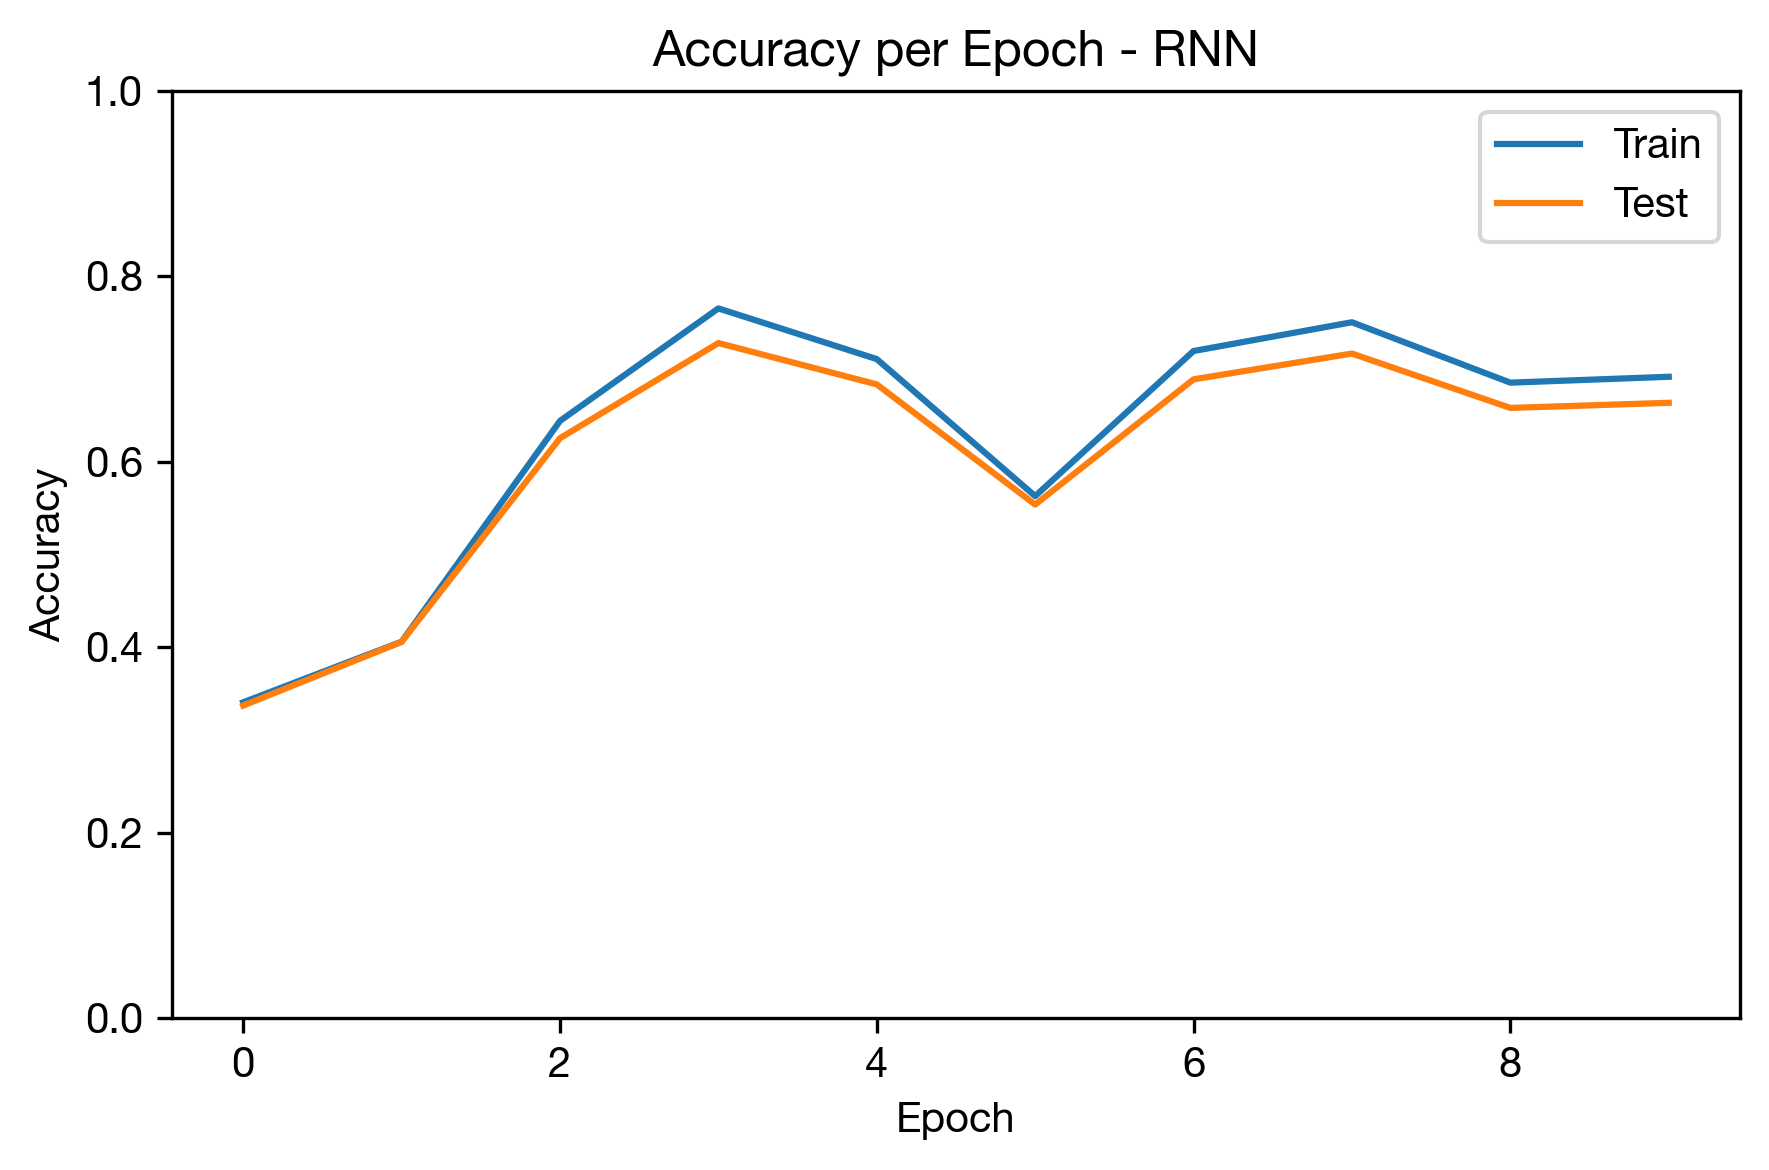

In [26]:
# Plot accuracy
plt.figure(figsize=(6, 4))
plt.plot(rnn_results["train_accuracies"], label="Train")
plt.plot(rnn_results["test_accuracies"], label="Test")
plt.title("Accuracy per Epoch - RNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
rnn_results

{'model': RNNClassifier(
   (embedding): Embedding(34396, 100, padding_idx=0)
   (rnn): RNN(100, 128, batch_first=True)
   (fc): Linear(in_features=128, out_features=3, bias=True)
   (activation): LogSoftmax(dim=1)
 ),
 'model_path': 'models/best_rnn.pt',
 'train_accuracies': [0.34067264873318137,
  0.4060685235865699,
  0.6441751137132995,
  0.7655265140317921,
  0.7108583089378177,
  0.5630643946256758,
  0.7195644089292356,
  0.7505935977266875,
  0.6854265798281666,
  0.6917773603257398],
 'test_accuracies': [0.33719137347564027,
  0.40587516770459964,
  0.6255431626584433,
  0.7281483409759907,
  0.6835739602314824,
  0.5539157772482428,
  0.6890206051382687,
  0.7168145137067222,
  0.6581829832395523,
  0.6636897014357516],
 'confusion_matrix': array([[12953,  3177,   516],
        [ 2161, 10686,  3799],
        [  292,  3631, 12724]]),
 'classification_report': {'0.0': {'precision': 0.8407763209139296,
   'recall': 0.7781448996755977,
   'f1-score': 0.8082490952202671,
   'suppo

In [28]:
save_classification_report(
    rnn_results["labels"],
    rnn_results["preds"],
    "rnn_classification_report.png",
)

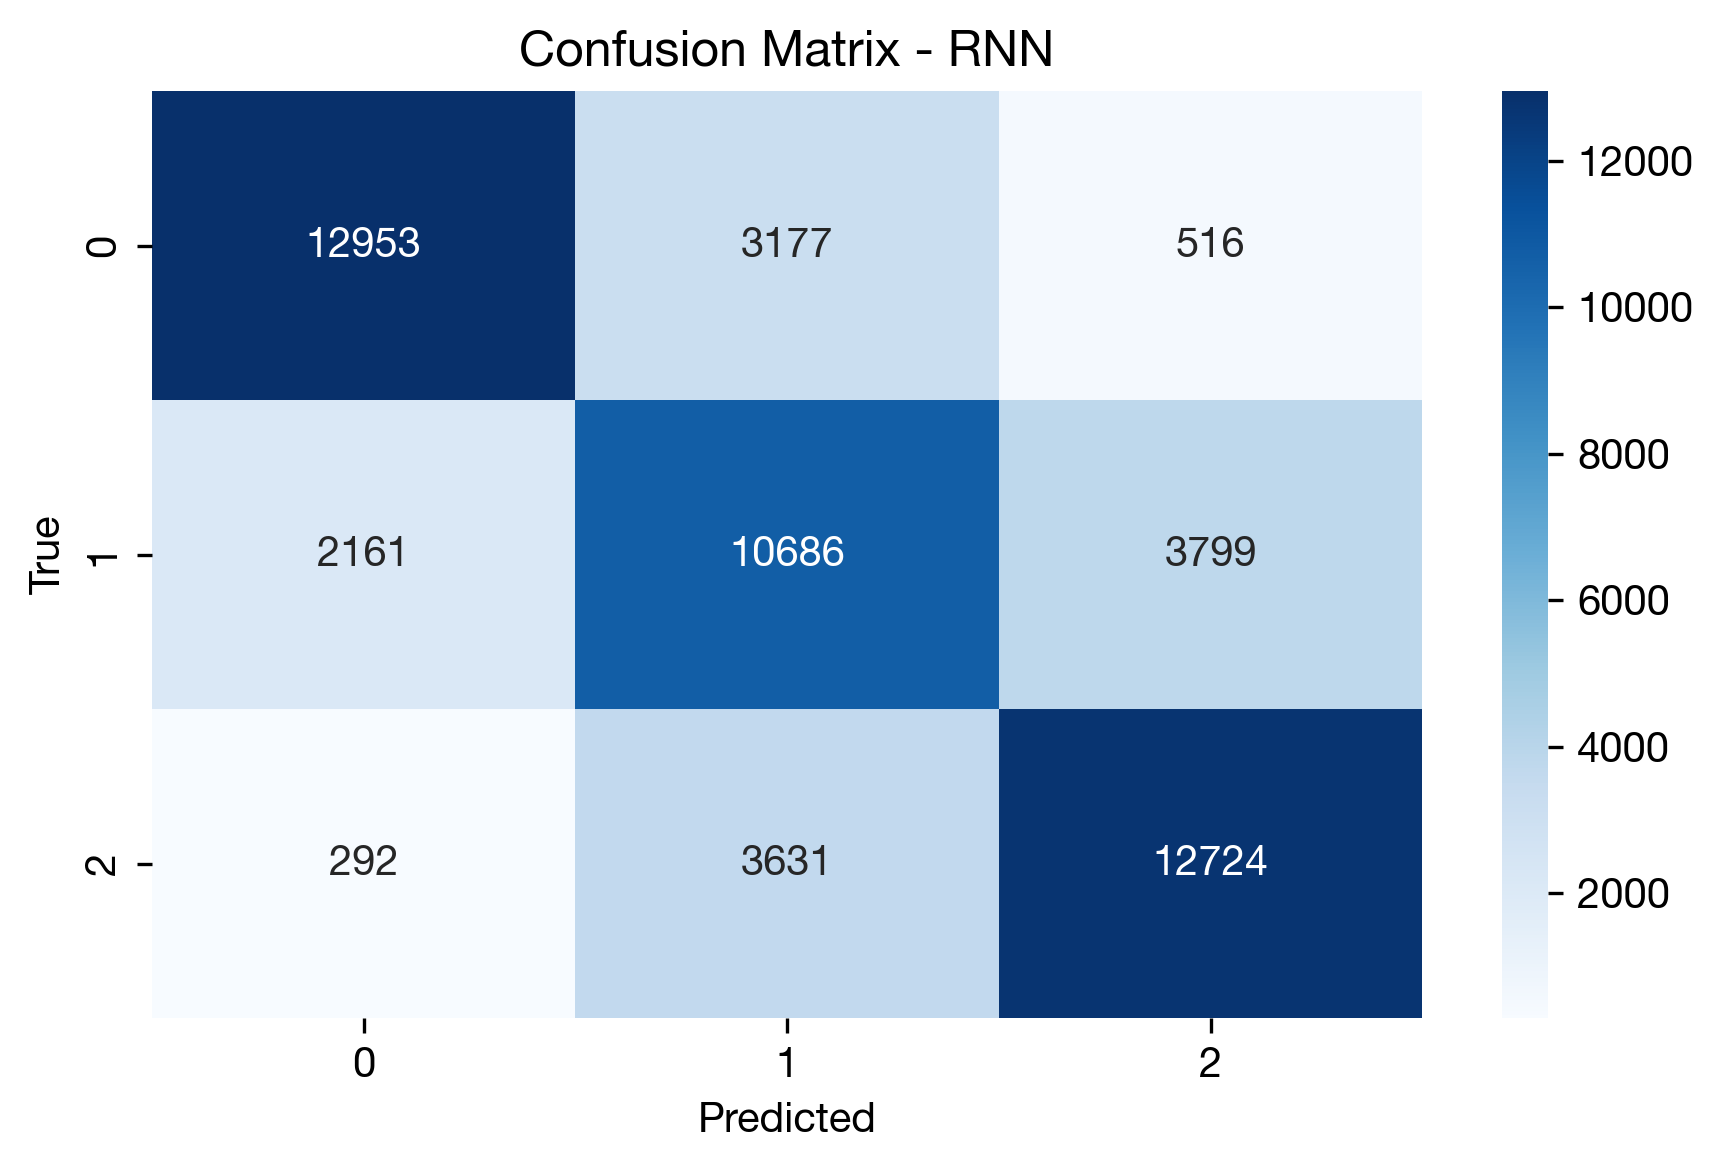

In [29]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(rnn_results["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - RNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [30]:
# Classification Report
pprint(rnn_results["classification_report"])

{'0.0': {'f1-score': 0.8082490952202671,
         'precision': 0.8407763209139296,
         'recall': 0.7781448996755977,
         'support': 16646.0},
 '1.0': {'f1-score': 0.6260105448154657,
         'precision': 0.6108380016005488,
         'recall': 0.6419560254715848,
         'support': 16646.0},
 '2.0': {'f1-score': 0.7554473668586357,
         'precision': 0.746757438816832,
         'recall': 0.7643419234696942,
         'support': 16647.0},
 'accuracy': 0.7281483409759907,
 'macro avg': {'f1-score': 0.7299023356314561,
               'precision': 0.7327905871104368,
               'recall': 0.7281476162056256,
               'support': 49939.0},
 'weighted avg': {'f1-score': 0.7299028471561407,
                  'precision': 0.7327908667886783,
                  'recall': 0.7281483409759907,
                  'support': 49939.0}}


In [31]:
def make_json_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [make_json_serializable(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        return obj.item()
    else:
        return obj

In [32]:
del rnn_results["model"]
del rnn_results["preds"]
del rnn_results["probs"]
rnn_results = make_json_serializable(rnn_results)

with open("results/rnn_results.json", "w") as f:
    json.dump(rnn_results, f, indent=2)

In [33]:
lstm_results = train_and_save_best(LSTMClassifier, "LSTM", bidirectional=True)

🧠 Training LSTM...
Epoch  1: Loss = 0.6482, Train Acc = 0.8522, Test Acc = 0.8175
Epoch  2: Loss = 0.3633, Train Acc = 0.9202, Test Acc = 0.8684
Epoch  3: Loss = 0.2347, Train Acc = 0.9472, Test Acc = 0.8842
Epoch  4: Loss = 0.1591, Train Acc = 0.9675, Test Acc = 0.8949
Epoch  5: Loss = 0.1105, Train Acc = 0.9771, Test Acc = 0.8986
Epoch  6: Loss = 0.0837, Train Acc = 0.9847, Test Acc = 0.9030
Epoch  7: Loss = 0.0649, Train Acc = 0.9876, Test Acc = 0.9031
Epoch  8: Loss = 0.0518, Train Acc = 0.9889, Test Acc = 0.9039
Epoch  9: Loss = 0.0429, Train Acc = 0.9916, Test Acc = 0.9069
Epoch 10: Loss = 0.0379, Train Acc = 0.9929, Test Acc = 0.9076
✅ Saved LSTM with Accuracy = 0.9076 → models/best_lstm.pt


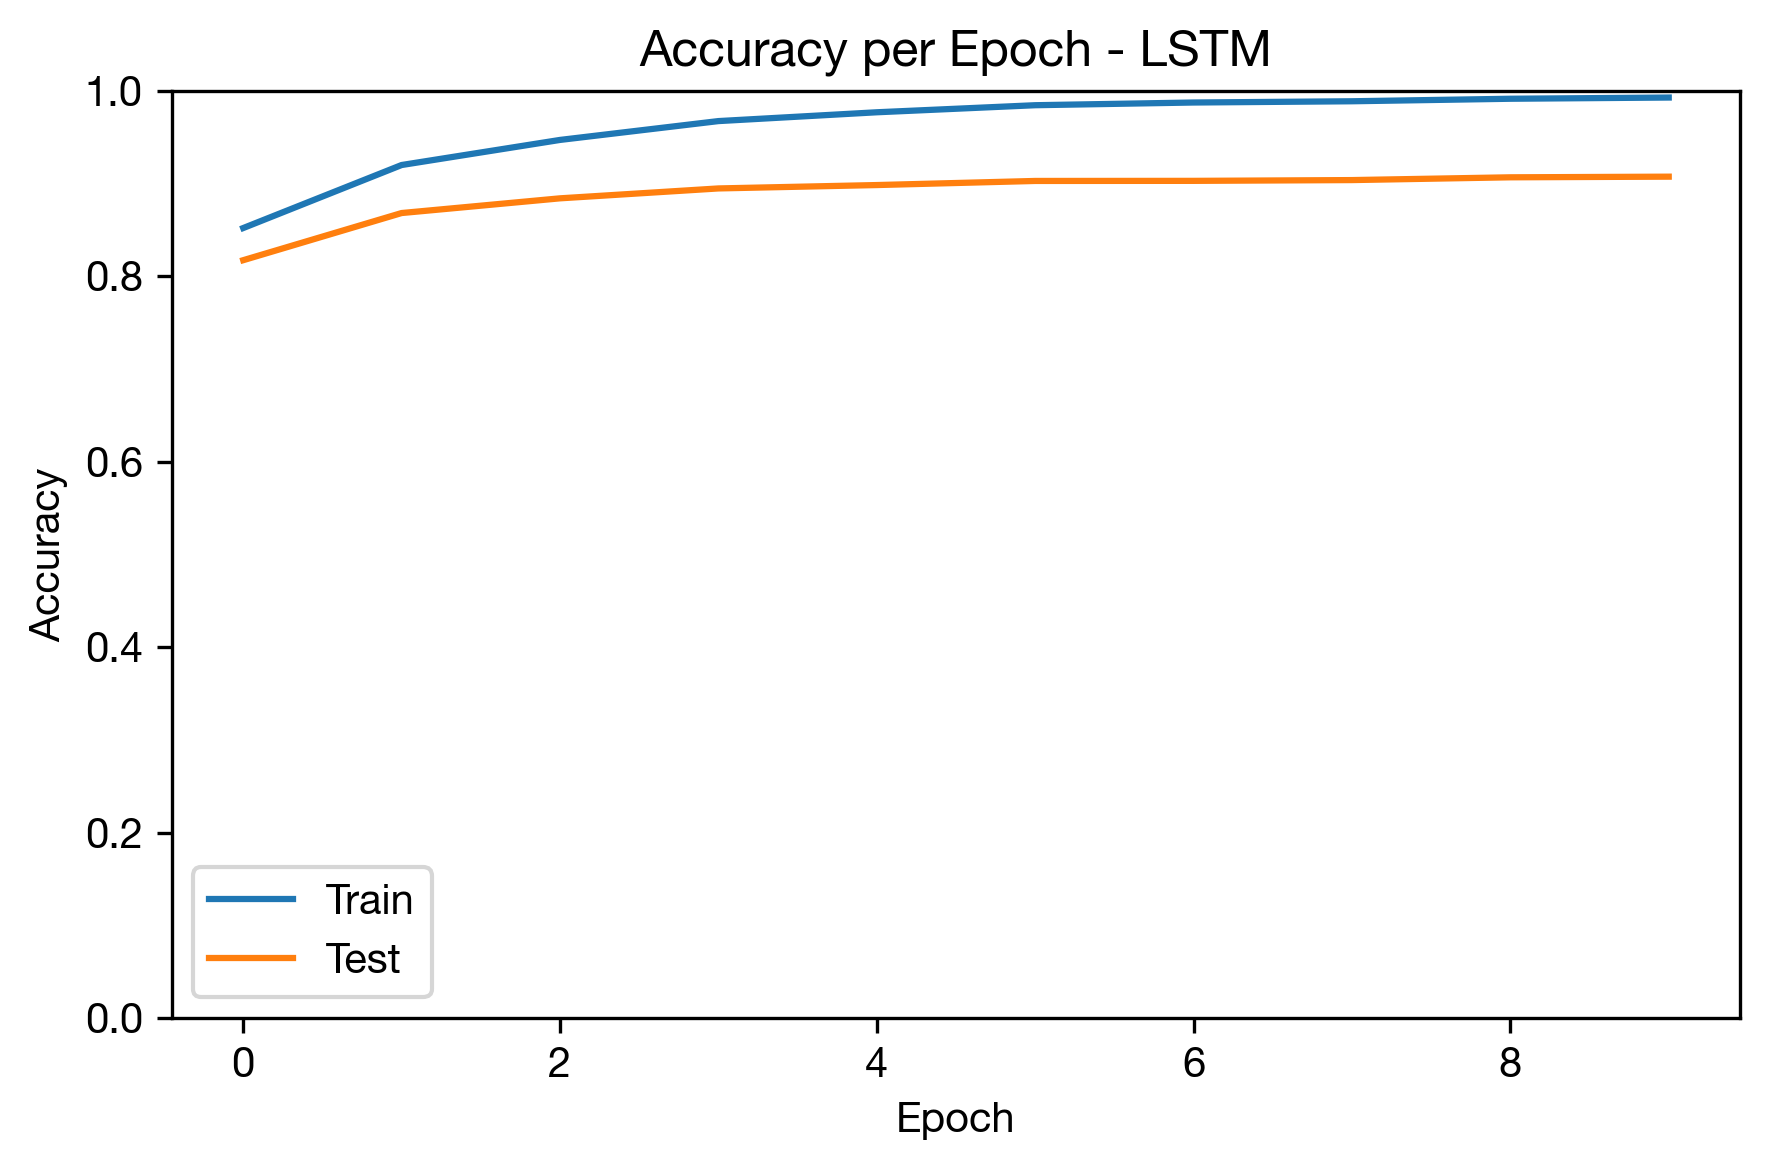

In [34]:
# Plot accuracy
plt.figure(figsize=(6, 4))
plt.plot(lstm_results["train_accuracies"], label="Train")
plt.plot(lstm_results["test_accuracies"], label="Test")
plt.title("Accuracy per Epoch - LSTM")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

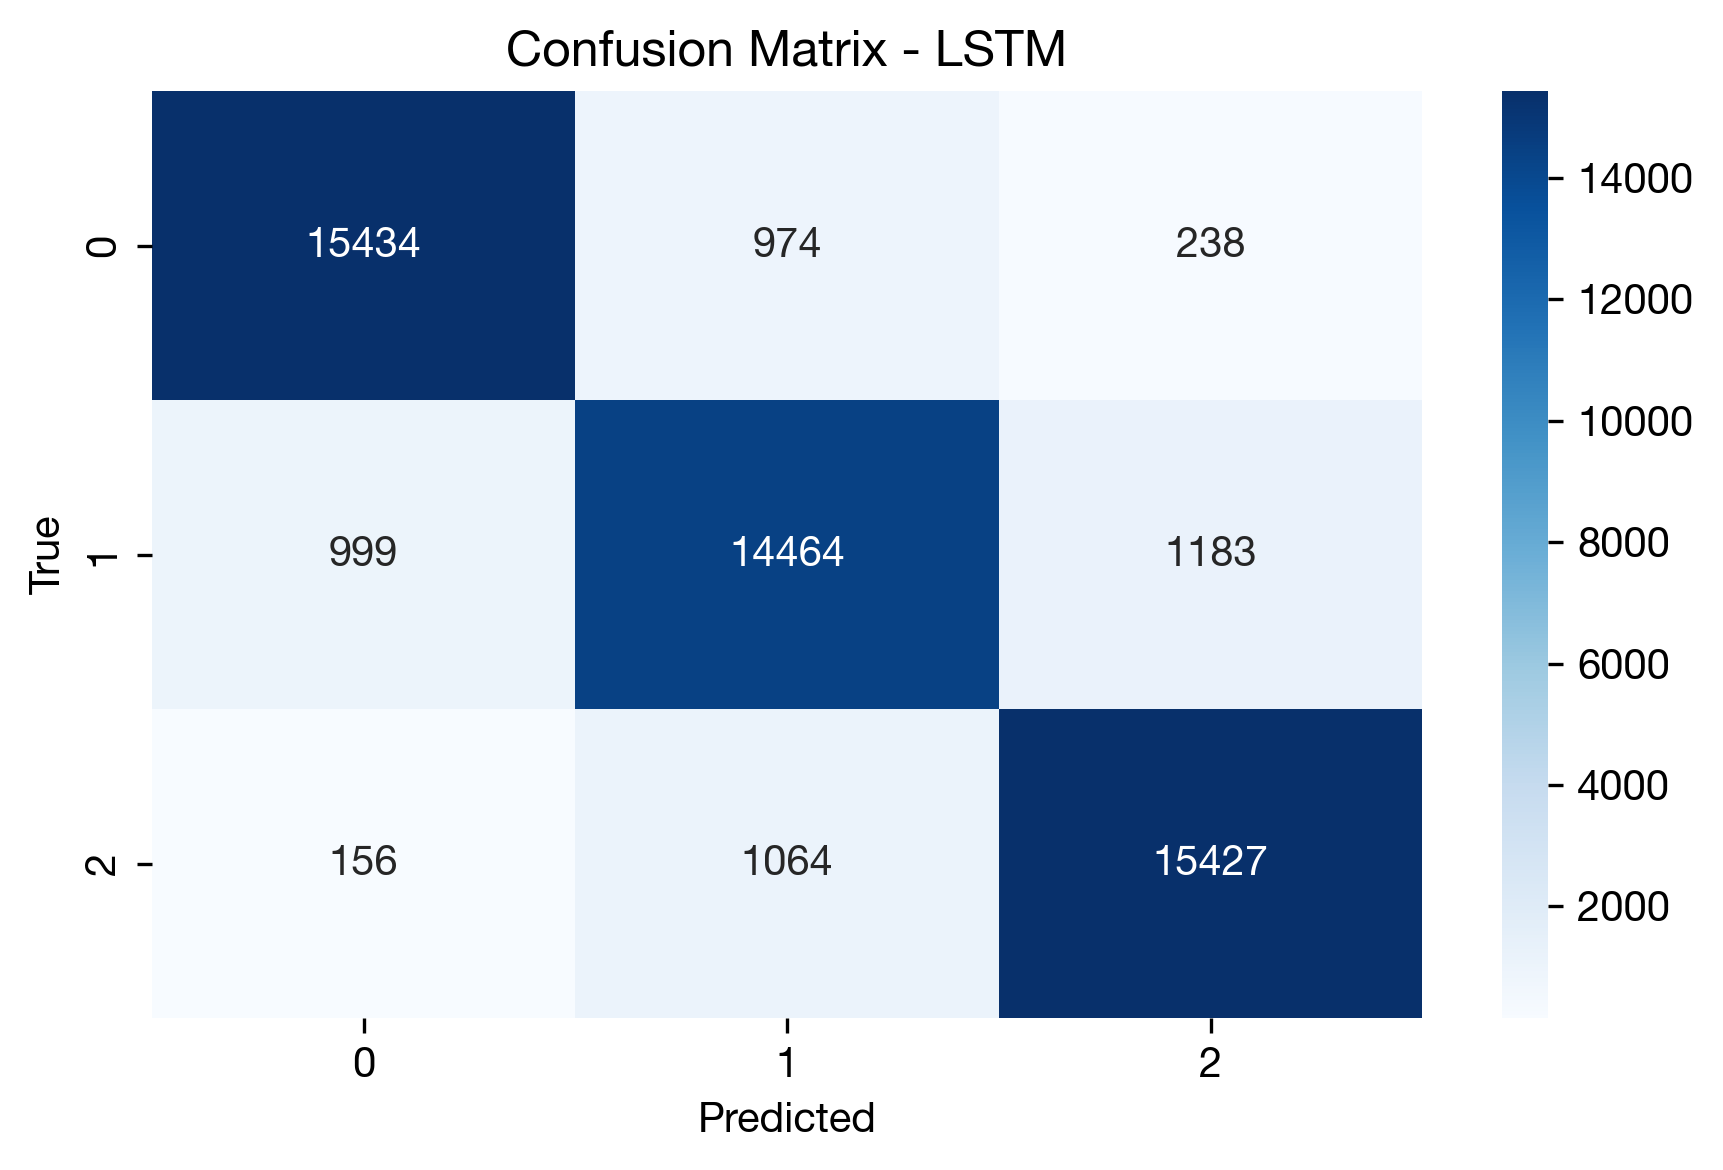

In [35]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(lstm_results["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [36]:
# Classification Report
pprint(lstm_results["classification_report"])

{'0.0': {'f1-score': 0.9287799007070859,
         'precision': 0.930375550063295,
         'recall': 0.9271897152469062,
         'support': 16646.0},
 '1.0': {'f1-score': 0.8726921684566188,
         'precision': 0.876499818203854,
         'recall': 0.8689174576474828,
         'support': 16646.0},
 '2.0': {'f1-score': 0.9211524108075833,
         'precision': 0.9156576448243114,
         'recall': 0.926713521955908,
         'support': 16647.0},
 'accuracy': 0.9076072808826768,
 'macro avg': {'f1-score': 0.9075414933237628,
               'precision': 0.9075110043638203,
               'recall': 0.9076068982834323,
               'support': 49939.0},
 'weighted avg': {'f1-score': 0.9075417658746244,
                  'precision': 0.9075111674956502,
                  'recall': 0.9076072808826768,
                  'support': 49939.0}}


In [37]:
save_classification_report(
    lstm_results["labels"],
    lstm_results["preds"],
    "lstm_classification_report.png",
)

In [38]:
del lstm_results["model"]
del lstm_results["preds"]
del lstm_results["probs"]
lstm_results = make_json_serializable(lstm_results)

with open("results/lstm_results.json", "w") as f:
    json.dump(lstm_results, f, indent=2)